# Dezinformacijos atpažinimas socialiniuose tinkluose
Tikslas sukurti programą, kuri išanalizuotų pateiktą tekstą anglų kalba iš socialinių tinklų ar straipsnių ir nurodytų ar duotas tekstas yra dezinformacija ar tiesa.

In [1]:
%pip install pandas matplotlib seaborn scikit-learn nltk joblib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.1 MB 7.8 MB/s eta 0:00:01
   ---------------------- ----------------- 4.5/8.1 MB 11.5 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.1 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 11.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 11.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------- ----------- 1.6/2.2 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 7.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------------------------------- ---- 2.4/2.7 MB 12.1 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 11.2 MB/s eta 0:00:00
Note: you may need to restart the 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Bibliotekų importavimas ir duomenų nuskaitymas

Total words in combined corpus: 37995032
Number of samples: 85954


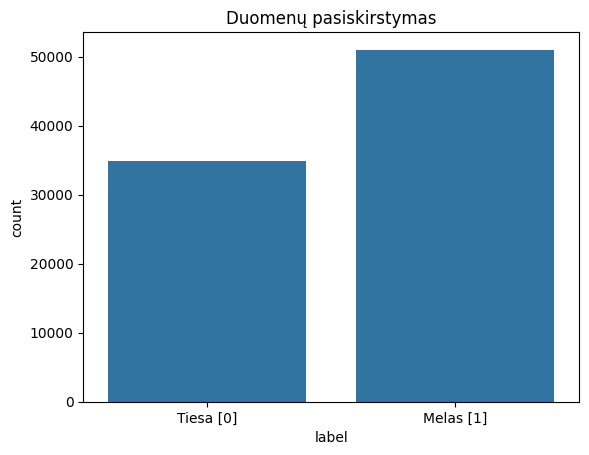

In [15]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load datasets
data_dir = Path("data")
fake_df = pd.read_csv(data_dir / "DataSet_Misinfo_FAKE.csv")
true_df = pd.read_csv(data_dir / "DataSet_Misinfo_TRUE.csv")
russian_df = pd.read_csv(data_dir / "EXTRA_RussianPropagandaSubset.csv")

# Label the datasets
fake_df["label"] = 1
russian_df["label"] = 1
true_df["label"] = 0

# Standardize text column names
for df in [fake_df, true_df, russian_df]:
    df.columns = [col.lower() for col in df.columns]

# Choose text column
text_column = "text" if "text" in fake_df.columns else list(fake_df.columns)[0]

# Select columns
fake_df = fake_df[[text_column, "label"]].dropna()
true_df = true_df[[text_column, "label"]].dropna()
russian_df = russian_df[[text_column, "label"]].dropna()

# Combine
df = pd.concat([fake_df, true_df, russian_df], ignore_index=True).sample(frac=1, random_state=42)
df.reset_index(drop=True, inplace=True)

# Word count
df["word_count"] = df[text_column].apply(lambda x: len(str(x).split()))
total_words = df["word_count"].sum()
print(f"Total words in combined corpus: {total_words}")
print(f"Number of samples: {len(df)}")

# Plot label distribution
sns.countplot(data=df, x="label")
plt.title("Duomenų pasiskirstymas")
plt.xticks(ticks=[0, 1], labels=["Tiesa [0]", "Melas [1]"])
plt.show()

## 2. Tekstyno apdorojimas ir normalizavimas

In [22]:

import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

def normalize_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df[text_column].apply(normalize_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aras\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3. Modelio apmokymas ir testavimas

In [25]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
print("Tikslumas:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Tikslumas: 94.99 %

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      6989
           1       0.95      0.97      0.96     10202

    accuracy                           0.95     17191
   macro avg       0.95      0.95      0.95     17191
weighted avg       0.95      0.95      0.95     17191


Confusion Matrix:
 [[6484  505]
 [ 357 9845]]


## 4. Požymių analizė ir interpretacija

In [ ]:

import numpy as np

feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = model.coef_[0]

top_fake = feature_names[np.argsort(coefficients)[-20:]]
top_true = feature_names[np.argsort(coefficients)[:20]]

print("Dažniausi žodžiai pasitaikantys dezinformacijoje:\n", list(reversed(top_fake)))
print("Dažniausi žodžiai pasitaikantys tiesoje:\n", list(top_true))

Top terms predicting FAKE news:
 ['via', 'imag', 'octob', 'imag via', 'hillari', 'novemb', 'ukrain', 'wire', 'uk', 'ukrainian', 'presid trump', 'entir', 'pm', 'fbi', 'howev', 'obama', 'saidth', 'share', 'get', 'nbsp']
Top terms predicting TRUE news:
 ['said', 'presid donald', 'twitter', 'thursday', 'friday', 'tuesday', 'wednesday', 'monday', 'the', 'com', 'we', 'sunday', 'it', 'follow', 'follow twitter', 'saturday', 'that', 'there', 'said statement', 'pic twitter']


## 6. Duoto teksto vertinimas

In [13]:
def predict_text(text):
    text_clean = normalize_text(text)
    text_vec = vectorizer.transform([text_clean])
    pred = model.predict(text_vec)[0]
    label = "🚫 Dezinformacija" if pred == 1 else "✅ Patikima"
    print(f"Prediction: {label}")

# https://www.bbc.com/news/articles/cwy67y8834yo
predict_text("""
In a groundbreaking revelation, alternative medicine proponents claim that consuming raw garlic daily can prevent and cure COVID-19. The article quotes several unverified ‘experts’ stating that garlic’s natural antiviral properties make vaccines and other treatments unnecessary. It encourages people to replace their medications with garlic supplements and shares testimonials of ‘miraculous recoveries.’ Medical professionals warn against such claims, emphasizing that no scientific studies support garlic as an effective COVID-19 treatment.

""")

Prediction: 🚫 Dezinformacija


## 6. Apibrendrinimas

Modeliui apmokyti buvo panaudota apie 30 000 tiesos sakinių ir apie 50 000 dezinformacijos sakinių. Pavyko sukurti ir apmokyti modelį, kuris pagal duotus duomenis turėjo 95% tikslumą.